# Basic Whitebox Misclassification Attack Example

## 1. Setup and Imports

This cell imports all the necessary modules from the `adversarial_lab` library, as well as other common libraries like TensorFlow, NumPy, and PIL for image manipulation and numerical operations.

Key `adversarial_lab` modules used:
* `PGD`: Projected Gradient Descent optimizer used to generate adversarial noise.
* `CategoricalCrossEntropy`: Loss function to guide the optimization.
* `WhiteBoxMisclassification`: The main attacker class.
* `AdditiveNoiseGenerator`: Generates the initial noise (can be zeros, random, etc.).
* `PreprocessingFromFunction`: Wraps a custom preprocessing function.
* `POClip`, `PONoisedSampleBounding`: Constraints applied to the noise or the noisy sample.
* `Plotting`: Utility for visualizing images and noise.

In [1]:
from adversarial_lab.core.optimizers import PGD
from adversarial_lab.callbacks import EarlyStopping
from adversarial_lab.core.losses import CategoricalCrossEntropy
from adversarial_lab.attacker.inference import WhiteBoxMisclassificationAttack
from adversarial_lab.core.noise_generators.tensor import AdditiveNoiseGenerator
from adversarial_lab.core.preprocessing import PreprocessingFromFunction
from adversarial_lab.core.constraints import POClip, PONoisedSampleBounding

from adversarial_lab.utils import Plotting

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

## 2. Model Selection and Loading

Here, you can choose which pre-trained model to attack. The supported models are `InceptionV3`, `ResNet50`, and `MobileNetV2`.
The subsequent code cell will load the chosen Keras application model with pre-trained ImageNet weights and set the appropriate `input_shape` and model-specific `preprocess_input` and `decode_predictions` functions.


In [2]:
MODEL = "InceptionV3"       # Supported models: InceptionV3, ResNet50, MobileNetV2

In [3]:
if MODEL == "InceptionV3":
    from tensorflow.keras.applications import InceptionV3
    from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
    model = InceptionV3(weights='imagenet')
    input_shape = (299, 299, 3)
elif MODEL == "ResNet50":
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
    model = ResNet50(weights='imagenet')
    input_shape = (224, 224, 3)
elif MODEL == "MobileNetV2":
    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
    model = MobileNetV2(weights='imagenet')
    input_shape = (224, 224, 3)

## 3. Image Preprocessing Function

Neural network models expect input data in a specific format. This `preprocess` function handles:
* **Type Casting**: Converts the input image data to `float32`.
* **Grayscale to RGB**: Converts grayscale images (2D or 3D with 1 channel) to 3-channel RGB format, as expected by the pre-trained models.
* **Resizing**: Resizes the image to the model's required input dimensions (e.g., (299, 299) for InceptionV3).
* **Batch Dimension**: Adds a batch dimension to the image tensor, as models typically expect batches of images.
* **Model-Specific Preprocessing**: Applies the specific preprocessing steps required by the chosen Keras model (e.g., scaling pixel values to a certain range like [-1, 1] or [0, 1], or BGR conversion if necessary).

In [4]:
def preprocess(sample, *args, **kwargs):
    input_sample = tf.cast(sample, dtype=tf.float32)
    if len(input_sample.shape) == 2:
        input_sample = tf.expand_dims(input_sample, axis=-1)
        input_sample = tf.image.grayscale_to_rgb(input_sample)

    elif len(input_sample.shape) == 3 and input_sample.shape[-1] == 1:
        input_sample = tf.image.grayscale_to_rgb(input_sample)

    input_tensor = tf.convert_to_tensor(input_sample, dtype=tf.float32)
    resized_image = tf.image.resize(input_tensor, (299, 299))
    batch_image = tf.expand_dims(resized_image, axis=0)
    return preprocess_input(batch_image)

## 4. Load and Classify Original Image

This cell loads an example image (`panda.jpg`). We then preprocess it and get the model's prediction on this original image. This establishes a baseline classification before applying any adversarial attack. The top predicted classes and their probabilities are displayed.


In [5]:
image = Image.open('data/panda.jpg')
image_array = np.array(image)

predictions = model.predict(preprocess(image_array), verbose=0)
print("Predicted class:", decode_predictions(predictions, top=1)[0][0][1])
print("Predicted class index:", np.argmax(predictions, axis=1)[0])
print("Predicted class probability:", np.max(predictions, axis=1)[0])


Predicted class: giant_panda
Predicted class index: 388
Predicted class probability: 0.91791785


## 5. Configure the Adversarial Attack Components

Now, we set up the components required for the `WhiteBoxMisclassification` attacker:
* **Loss Function**: `CategoricalCrossEntropy` is used. For misclassification, the goal is to maximize this loss with respect to the original class or minimize it towards a target class.
* **Optimizer**: `PGD` (Projected Gradient Descent) is chosen. This is an iterative optimization algorithm that takes steps in the direction of the gradient of the loss function and then projects the resulting perturbation back onto a constrained space (e.g., an L-infinity ball). The `learning_rate` (or step size) for PGD is set here.
* **Constraints**:
    * `POClip`: This "Perturbation Operation" clips the generated noise values to a specific range (e.g., between -2 and +2). This limits the magnitude of individual pixel changes in the noise.
    * `PONoisedSampleBounding`: This ensures that the pixel values of the *adversarial image* (original image + noise) remain within a valid range (e.g., 0 to 255 for standard images).
* **Noise Generator**: `AdditiveNoiseGenerator` is used.
    * `dist="zeros"`: Initializes the noise with all zeros. The PGD optimizer will then iteratively modify this noise.
    * `scale=[0, 255]`: Informs the generator about the typical range of the input data it will be added to. This is more relevant if a random distribution (like "uniform" or "normal") was used for `dist`. For `dist="zeros"`, `PONoisedSampleBounding` is key.
* **Preprocessing Wrapper**: `PreprocessingFromFunction.create(preprocess)` wraps our custom `preprocess` function so it can be seamlessly integrated into the attacker's workflow. The attacker will use this to preprocess images before feeding them to the model during the attack process.


In [6]:
loss = CategoricalCrossEntropy()
optimizer = PGD(learning_rate=1.0)

constrain1 = POClip(min=-2, max=2)
constrain2 = PONoisedSampleBounding(min=0, max=255)
constraints = [constrain1, constrain2]

noise_generator = AdditiveNoiseGenerator(scale=[0, 255], dist="zeros")
preprocessing = PreprocessingFromFunction.create(preprocess)

early_stopping_non_targetted = EarlyStopping(trigger="misclassification")
early_stopping_targetted = EarlyStopping(trigger="misclassification", target_class=924, confidence=0.5)

## 6. Initialize the Attacker

With all components defined, we initialize the `WhiteBoxMisclassification` attacker.
* `model`: The target neural network.
* `optimizer`: The PGD optimizer configured above.
* `loss`: The categorical cross-entropy loss function.
* `noise_generator`: The additive noise generator.
* `constraints`: The list of constraints to apply during noise generation.
* `preprocessing`: The wrapped preprocessing function.
* `verbose`: Controls the amount of logging output during the attack (0: silent, 1: progress bar, 2: epoch results, 3: detailed step results).


In [7]:
attacker = WhiteBoxMisclassificationAttack(
    model=model,
    optimizer=optimizer,
    loss=loss,
    noise_generator=noise_generator,
    constraints=constraints,
    preprocessing=preprocessing,
    callbacks=[early_stopping_targetted],
    verbose=3)

## 7. Perform a Targeted Misclassification Attack

In a targeted attack, we aim to make the model classify the input image as a *specific* incorrect class.
* `image_array`: The original input image as a NumPy array.
* `target_class`: The integer index of the target class we want the model to predict. For ImageNet, class 924 is "sports_car". You can find other ImageNet class IDs online or by exploring `decode_predictions` output for various images.
* `epochs`: The number of iterations the PGD optimizer will run to craft the adversarial noise.
* `on_original=True`: Specifies that the attack generates noise to be added to the *original, unnormalized* image. If `False`, it would expect the input `image_array` to be already preprocessed and generate noise accordingly.

The `attacker.attack()` method returns the generated adversarial noise.


In [8]:
noise, noise_meta = attacker.attack(image_array, 
                        target_class=924,
                        epochs=20, 
                        on_original=True)

Attacking:   0%|          | 0/20 [00:00<?, ?it/s]

Attacking:  20%|██        | 4/20 [00:04<00:14,  1.08it/s, Loss=3.88, Prediction (score)=924(0.869), Original Class (score)=388(0.002), Target Class (score)=924(0.869)]

## 8. Visualize Targeted Attack Results and Verify

We use `Plotting.plot_images_and_noise` to display:
1.  The original image.
2.  The generated adversarial noise (magnified for visibility, as it's often subtle).
3.  The resulting adversarial image (original + noise).

We then preprocess the adversarial image and feed it to the model to see if the attack was successful in forcing the targeted misclassification.


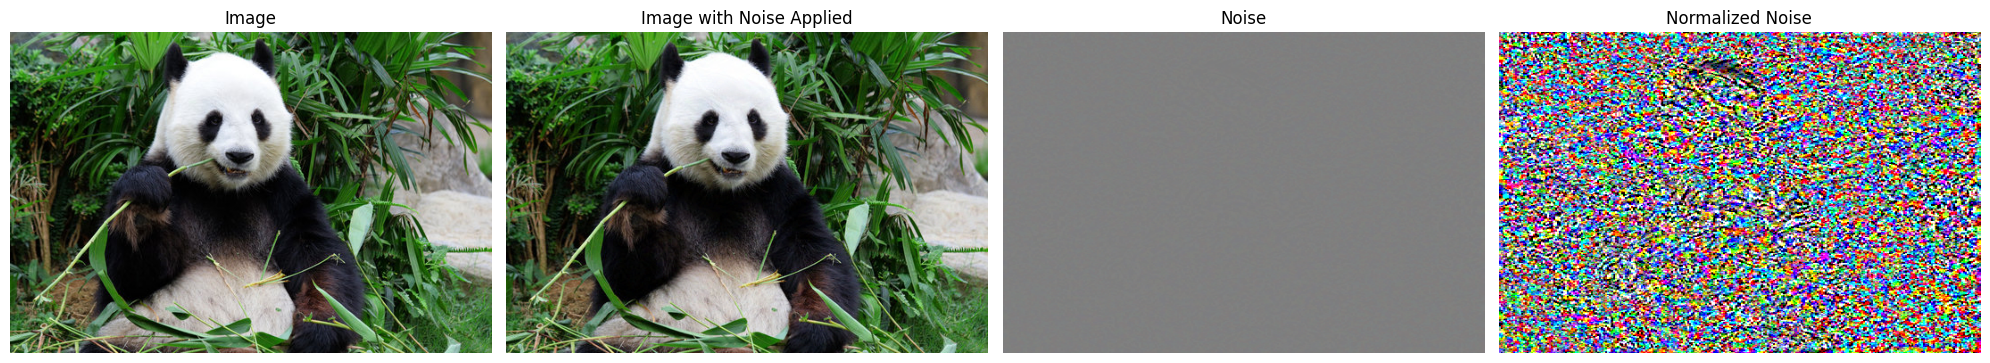

In [9]:
Plotting.plot_images_and_noise(image_array, noise)

## 9. Perform an Untargeted Misclassification Attack (Random Strategy)

In an untargeted attack, the goal is to make the model misclassify the image as *any* class other than the original correct class.
* `strategy="random"`: This tells the attacker to randomly pick a class (that is not the original true class) as the misclassification target for each iteration or for the overall attack. The library might also support other strategies like "least_likely" (targeting the class the model deems least probable for the original image).
* `target_class` is omitted when using a strategy like "random" as the attacker determines the target internally.
* `original_class_index` (calculated in Cell 4) is implicitly used by the attacker with `strategy="random"` to ensure the random target is not the original class.


In [11]:
attacker = WhiteBoxMisclassificationAttack(
    model=model,
    optimizer=optimizer,
    loss=loss,
    noise_generator=noise_generator,
    constraints=constraints,
    preprocessing=preprocessing,
    callbacks=[early_stopping_non_targetted],
    verbose=3)

noise, noise_meta = attacker.attack(image_array, 
                        epochs=20, 
                        strategy="random",
                        on_original=True)

Attacking:  30%|███       | 6/20 [00:05<00:11,  1.17it/s, Loss=3.5, Prediction (score)=686(0.366), Original Class (score)=388(0.278), Target Class (score)=686(0.366)] 

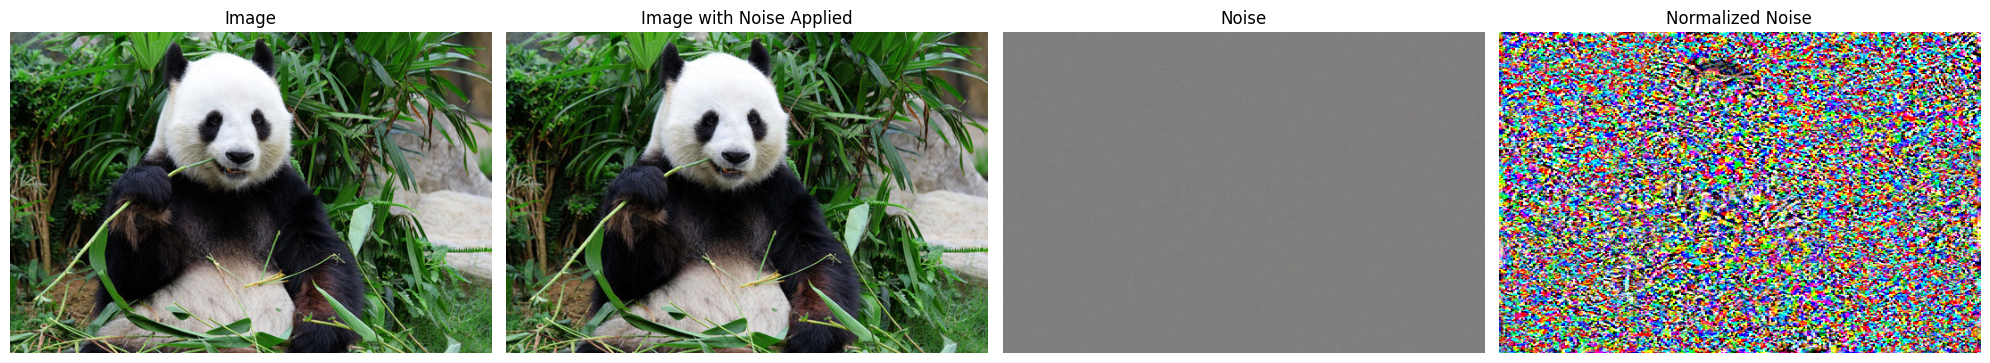

In [12]:
Plotting.plot_images_and_noise(image_array, noise)

## 11. Conclusion

This notebook demonstrated how to perform basic white-box targeted and untargeted misclassification attacks using the `adversarial_lab` library. We saw how relatively small, often imperceptible, perturbations can drastically change a deep neural network's predictions.

**Further Exploration:**
* Try different models (`ResNet50`, `MobileNetV2`).
* Experiment with different `learning_rate` values for PGD and `epochs`.
* Adjust the `POClip` constraint value for the noise.
* Test with different images.
* Explore other attack types or optimizers if available in the library.
* Investigate other untargeted strategies like "least_likely".